In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
try:
    from keras.utils import np_utils
except:
    pass
try:
    from tensorflow.keras import utils as np_utils
except:
    pass

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

import platform

plat = platform.system()
print("Platform: ", plat)
if ("M2" in plat) or ("arm" in plat) or ("Darwin" in plat) or ("M1" in plat) or ("M3" in plat):
    is_Apple_silicon = True
    optimizer = tf.keras.optimizers.legacy.Adam()
    print("Apple Silicon")
else:
    is_Apple_silicon = False
    #optimizer = tf.optimizers.Adam()
    optimizer = tf.keras.optimizers.legacy.Adam()
    print("Non-Apple Silicon")

error_metric_used = 'mean_squared_error'

Platform:  Darwin
Apple Silicon


In [2]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

# Keras, TensorFlow, and Neural Network Regression

As we have seen, neural networks aren't quite as complex as they appear at first, however we still generally don't want to have to build them from scratch very often. The libraries that we will primarily use for creating neural network models are TensorFlow and Keras. Keras and TensorFlow combine to be roughly what sklearn was for the other types of models we've used. 

### Tensorflow

Tensorflow, developed by Google, is one of the most popular libraries for neural networks. 

### Keras

Keras is another package that provides an an API offering an easier to use interface to TensorFlow, allowing us to use it with code that is higher level, avoiding much of the linear math that can make Tensorflow frustrating. Since its introduction Keras has been wrapped in with TensorFlow and the two are normally now blended together as far as we are concerned. 

### Other Alternatives

Keras and Tensorflow are not the only libraries of neural networks, the primary competitor to Tensorflow is PyTorch, which was developed by Facebook. PyTorch does pretty much the same thing as Tensorflow, we won't look at it here. The concepts and theory of PyTorch models is the same as with the TensorFlow ones, but the code and implementation details is different. 

PyTorch is gaining popularity, particularly with some of the large language models and other generative models that have been developed in the past few years. In these domains PyTorch is more popular and more widely used. If these types of applications are important to you, it is likely a good idea to get comfortable with PyTorch - if you are comfortable with the TensorFlow stuff it will be a pretty easy adaptation, mainly just learning a different syntax and familiarizing yourself with a different API. 

### Optimization and Efficiency Notes

Neural networks are very computationally expensive, and can take a long time to train. As we move into looking at some larger models in the near future, the processing time on a typical laptop will become prohibitive. We will utilize Google Colab for some of these examples, which will allow us to borrow some GPU processing that is often drastically faster than what we can get on our own machines.

If you happen to have a machine with an nVidia GPU, an M1/M2/M3 Mac, or potentially a couple of other GPUs, you can install an optimized version of TensorFlow on your machine that will allow this stuff to use your GPU and be way faster without using Colab. This isn't required, but it is a good idea if your computer is capable. You can google "install tensorflow GPU/Apple Silicon" or similar for your GPU and there will be some pretty simple step-by-step instructions. If available, this will make a big difference in the speed of your models. 

In some of the larger exercises you will need to use some kind of GPU based acceleration to make things practical - the free version of Colab will work, though potentially with some annoyance. My recommendation is to use a paid version of Colab for that time if you don't have a machine that can handle it. 

## Remote Data and Google Colab

Below we'll load some data, however here we'll load something from a data repository that I setup on Azure, rather than the desktop, as we normally would. This is easy to do, we just change the path to the URL and use our "read_csv" as usual. The reason for this is that we are going to use Google Colab for some of the processing here, and if we are loading data from some static location, like this server address, we don't need to worry about loading data files and maintaining file paths. This will likely be something that you need to at least pay some attention to if you are using Colab. The key thing to remember is that it doesn't matter where the data is stored, as long as you can get to it. So if we need to change the data to make things work, we may have to change the loading bit to make it work. 

#### Your Remote Data

If you have a large-ish dataset that you're using, you can do the same thing. The datasets can be loaded directly from your github repository URL, as long as you get the "Raw" URL from Github. Click on the raw link on a file, then use the URL of the resulting page:

![Raw Link](images/github_raw.png "Raw Link")

Then you can use that URL to load the data. If you have data that comes from some site on the internet, you can likely load it similarly, assuming there's no security on the site blocking you from loading it. If there's something that doesn't work in any reasonable way, let me know, we might be able to put it on this Azure repository. I can't promise that in every situation though, it isn't free - though Azure, AWS, and Google Cloud all have free access of various levels that you could sign up for and use, if you wanted to. You can also save stuff to your Google Drive, and then load it from there - Google instructions if you need to do this - we can load up a function that connects and authenticates our program into your Google Drive and from there it will act like any other source. 

### Google Colab

As noted, we'll use Colab for some of our neural network stuff, as it gives us GPU access, which is massively helpful in many situations. The URL for Colab is https://colab.research.google.com/ and you can sign in with your Google account. Once on Colab, it works pretty much like Jupyter notebooks. To load data from Github, we can go to File->Open Notebook->Github, and then paste in the URL of the repository we want to load and select the notebook. Once loaded, it is basically a normal notebook. The one thing to pay attention to is that if there are any file loading bits in the code, those will fail, as noted above. 

Inside of Colab, the one key thing we want is to enable GPU acceleration. To do this, go to Edit->Notebook Settings, and then select GPU as the hardware accelerator. This will make a big difference in the speed of your models when using tensorflow. One thing to note is that while we get a bunch of GPU time for free, it is limited. So it is probably a waste to run huge tests with massive numbers of epochs, over and over, as you will likely run out of GPU time at some point. It will reset, but how much is allocated to each person is basically up to the whims of Google at any given moment. The "!" command below will print the details on the GPU that is currently being used.

I prefer to do all the editing in VS Code, save, upload to Github, then load and run the final code in a Colab window. This is more personal prefence than anything else, but it works well for me. You can also edit and save things in Colab, including back to Github, but you will likely need to do some authorization to allow access, and the process feels more annoying to me. For ease, I added this parameter to set the epochs globally for this notebook, so I can set it to a low number while working locally, then increase it when I want to test the actual performance on Colab. We could do a similar thing with sampling large datasets. 

In [3]:
BASE_EPOCHS = 100
!nvidia-smi -L

zsh:1: command not found: nvidia-smi


In [4]:
#df = pd.read_csv("data/house_data.csv")
df = pd.read_csv("https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/house_data.csv")
df.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

In [6]:
y = np.array(df["price"]).reshape(-1,1)
X = np.array(df.drop(columns={"price"}))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y)

(21613, 18) (21613, 1)


## Create a Neural Network Model

Creating a NN model is slightly different from the normal process that we are used to in sklearn. We need to do a little more work to set it up. 

### Create Model and Add Layers

First we need to make a NN model, it comes "empty". We will use a sequential model, which is the most simple type but is less configurable (which we don't care about much right now). The limitation of sequential models is that they can only take in one tensor and only output one tensor. The other options here are "functional", which allows for the structure of the model to be configured, and "model subclassing", which allows you to build almost everything from scratch. These other types are more complex and more flexible, but actually aren't really needed for most applications, and we won't use them. These more complex models are commonly used for scenarios where the data is complex, such as a self driving car - a model needs to output steering as well as velocity. Also for more complex problems such as language or image processing, this flexibility allows for models to be created that are better able to extract the information from the data.

#### Layers

Next we need to add some layers. We will start simple with only two "thinking" layers, and one to do some processing. We can think of the layers roughly like steps of the sklearn pipeline, with data entering at the first layer and predictions flowing out of the final layer. 

In addition to "normal" neural network layers, there are many other types that can do all kinds of other stuff. One example we will use here is the normalization one at the front. This layer does exactly what you'd expect - it normalizes our data so the rest of the network can use it. The normalize layer will also automatically handle the 2D nature of the data that we are used to, so we don't need to worry about that aspect here. Other layers can do everything from regularization to image processing, they are also commonly inhierited for developers to create custom layers targeting specific tasks. We'll use a few of the other ones as we move through some more complex models.

![Keras Layers](images/keras_layers.jpg "Keras Layers")

#### Dense Layers

We'll use dense layers here, and they are the main building block in our models. When adding the layer we need to specify a couple of things. One is the input dimensions - we need to tell the network what the shape of the incomming data is. 

The other argument is the units, which represents the output dimension. When using these Keras dense layers we don't need to specify each layer's input/output like we did when we made it by hand. We specify both, using units and input_dim, for the first layer that takes in the input; for subsequent layers we can just specify the output and Keras will automatically figure the rest out. 

Note that there is also an input layer that can be added, we can avoid the need for it by using the input_dim or input_shape as shown below. The two examples there do the same thing, since the input is flat - 18 features. If we are dealing with inputs that do not start out as flat, such as in an image, use the input_shape since you can specify all dimensions; we will see an example of this next time with some images. 

#### Activation Function

For each of our layers we need to define which activation function to use. For now we will use the ReLU function, which is probably the most popular. We'll look at other ones later on. Note that we've left the activation function off of the final layer - we are doing regression so we want that raw value. This is the same idea as with linear regression - we don't want the prediction to be transformed through something like the sigmoid, we just want the number.

#### Summary

After we've constructed the model, the summary command give us, well, a summary. 

We are dealing with a bunch of numerical inputs here, so we can add a normalization layer at the front end. Like with sklearn, we want to fit the normalization to the training data only. 

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(18, input_shape=(18,), activation='relu'))
model.add(Dense(1))
model.summary()

Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



2024-03-28 14:52:40.561850: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 18)               37        
 n)                                                              
                                                                 
 dense (Dense)               (None, 18)                342       
                                                                 
 dense_1 (Dense)             (None, 1)                 19        
                                                                 
Total params: 398
Trainable params: 361
Non-trainable params: 37
_________________________________________________________________


#### Compile Model

Once a model is created we need to compile it. The complie step basically builds the layers we specified above and the loss and optimization parameters below together into a usable model object. When compiling the model we are providing it with the things it needs to calculate error:

<ul>
<li> Loss - we can provide a loss function that we'd like to use. 
<li> Optimizer - the optimizer is the algorithm that the model will use to perform the gradient descent to find the lowest error. Adam is a very common choice.
<li> Learning rate - the learning rate is provided as a parameter of the optimizer. 
</ul>

##### Optimizing Adam

The optimizer is the algorithm used to perform the gradient descent and minimize error. For the most part this isn't something we need to be concerned about. The choice of optimizer is much more important if dealing with very large datasets because different optimizers have different levels of efficiency. For our purposes, we can use Adam and be pretty happy. Adam stands for Adaptive Moment Estimation which means basically that it will adjust itself depending on current gradients. It tends to be efficient both in time and memory, so it is very commonly used. 

<b>Note:</b> it is pretty common in tensorflow and keras to have things like the example below, where we can specify "adam" with either the name, or the full class with arguments. These different ways of doing things are generally interchangable, but it does make documentation more confusing, as the two different ways may often be interchanged. 

In [8]:
#model.compile(loss='error_metric', optimizer="adam")
model.compile(loss=error_metric_used, optimizer=optimizer)

### Fit the Model

The fit command does the same thing that we are used to, it trains the model, however there are some differences. The main difference is that batch_size is almost always set in neural networks, while the sklearn models just take all the data at once. 

What's a batch? Batches are just subsets of the data, so if the batch size is 100 the algorithm will grab 100 rows at a time before making an update to the weights and bias. There are a few reasons this exists:

<ul>
<li> Memory constraints - it is common with neural networks to deal with datasets that are extremely large. Processing data that can't fit entirely in RAM is very slow (the computer must swap data from the hard drive to RAM as it is needed) compared to data that is in RAM. Cutting the batch size can avoid this issue. 
<li> Speed - the math involved in the back propagation can sometimes be very computationally intensive. 
<li> Accuracy - batch size can have an impact on accuracy, though that impact is not very predictable. For the most part finding an optimal batch size will need to be grid-searched. 
</ul>

The fit command also has the epoch paramater, which instructs on how many times to work through ALL of the data. We want to ensure we have enough epochs to find the optimal solution. Training rounds, or epochs, are one of the key tuning factors when using neural networks. Similar to large trees, large neural networks are capable of learning the training data very well, and carry the same risk of overfitting. With neural networks, a common approach to tuning is to allow the model to train, and cut it off when we start overfitting, or when the testing accuracy starts to decrease.

#### Plot the Loss

One very common visualization we see with neural networks is a plot of both training and validation loss vs number of epochs. Generally we'll see the training loss drop - first sharply as the model initially fits itself, then more slowly as it becomes more fitted. The validation loss will usually somewhat mirror the training loss, except it will often reach a minimum at some point before again increasing. This minimum point is our best model, when the validation loss starts increasing again, that is a sign that the model has become overfitted - customized to the training data, but less and less generalizable to new data. 

Set the verbosity to 1 in the fit to get a full list of the loss for each epoch to pinpoint the exact "ideal" number of epochs. We'll look more at this in a minute. 

Epoch 1/100


130/130 [==============================] - 1s 6ms/step - loss: 425971908608.0000 - val_loss: 416282935296.0000
Epoch 2/100
130/130 [==============================] - 1s 5ms/step - loss: 425967222784.0000 - val_loss: 416276545536.0000
Epoch 3/100
130/130 [==============================] - 1s 5ms/step - loss: 425958637568.0000 - val_loss: 416265797632.0000
Epoch 4/100
130/130 [==============================] - 1s 4ms/step - loss: 425945366528.0000 - val_loss: 416250658816.0000
Epoch 5/100
130/130 [==============================] - 1s 4ms/step - loss: 425927540736.0000 - val_loss: 416230572032.0000
Epoch 6/100
130/130 [==============================] - 1s 5ms/step - loss: 425904898048.0000 - val_loss: 416205864960.0000
Epoch 7/100
130/130 [==============================] - 1s 6ms/step - loss: 425876881408.0000 - val_loss: 416175915008.0000
Epoch 8/100
130/130 [==============================] - 1s 8ms/step - loss: 425844342784.0000 - val_loss: 416141639680.0000
Epoch 9/100
130/130 [=======

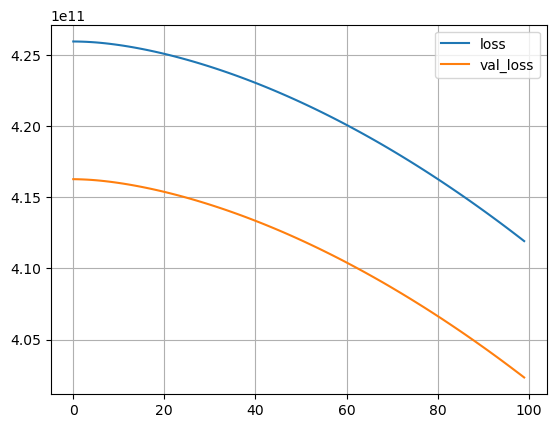

In [9]:
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=BASE_EPOCHS, validation_split=.2, verbose=1)
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Exercise

Make a simple neural network for predicting the price of homes in California. 

In [10]:
from sklearn.datasets import fetch_california_housing

cal = fetch_california_housing(as_frame=True)
Xcal = pd.DataFrame(cal.data)
ycal = pd.DataFrame(cal.target)
Xcal.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
ycal.head()

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [12]:
X_train_cal,  X_test_cal, y_train_cal, y_test_cal = train_test_split(Xcal, ycal)
X_train_cal.shape

(15480, 8)

In [13]:
cal_normalizer = tf.keras.layers.Normalization(axis=-1)
cal_normalizer.adapt(np.array(X_train_cal))

cal_model = Sequential()
cal_model.add(cal_normalizer)
cal_model.add(Dense(8, input_shape=(8,), activation='relu'))
cal_model.add(Dense(8, activation='relu'))
cal_model.add(Dense(1))
cal_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 170
Trainable params: 153
Non-trainable params: 17
_________________________________________________________________


Epoch 1/100
248/248 [==============================] - 2s 5ms/step - loss: 4.5311 - val_loss: 1.9534
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 1.0957 - val_loss: 0.8410
Epoch 3/100
248/248 [==============================] - 1s 5ms/step - loss: 0.6455 - val_loss: 0.6385
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 0.5062 - val_loss: 0.5244
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 0.4398 - val_loss: 0.4725
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 0.4112 - val_loss: 0.4528
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 0.3986 - val_loss: 0.4416
Epoch 8/100
248/248 [==============================] - 1s 4ms/step - loss: 0.3905 - val_loss: 0.4338
Epoch 9/100
248/248 [==============================] - 1s 4ms/step - loss: 0.3857 - val_loss: 0.4314
Epoch 10/100
248/248 [==============================] - 1s 4ms/step - loss: 0.3819 - val_lo

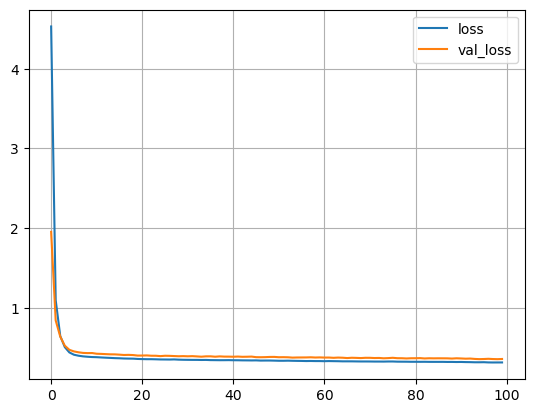

In [14]:
cal_model.compile(loss=error_metric_used, optimizer=tf.optimizers.Adam())
cal_train_log = cal_model.fit(X_train_cal, y_train_cal, epochs=BASE_EPOCHS, batch_size=50, validation_split=.2, verbose=1)
cal_model.evaluate(X_test_cal, y_test_cal)
plot_loss(cal_train_log)

## Basics of Overfitting and Underfitting in Neural Networks

Just like any other type of model, our primary task in trying to attain an accurate set of predictions is to balance the overfitting and underfitting. In a neural network, the ideas are the same as with standard models, however the tools and their usage can differ slightly. 

### Add Data

Adding data to the training set is the number one way to improve accuracy. As noted above, neural networks are commonly able to acheive very high accuracy levels if provided with very large training sets. For smaller datasets, the probability of a neural network being the best model is much lower than with big data. There isn't a replacement for having large amounts of data (though there are a few tricks that we'll look at later), and modern large neural networks are (usually) the best tool that is able to take advantage of all that data. 

In the near future we'll look at some common pre-trained models that people/orgs such as Google have shared, most notably ones that do things like image recognition. These models are typically trained on really large datasets - often 10s of GB or more. This massive amount of training data allows these models to be more accurate than anything that we could create, but would be unrealistic for most people to train just due to the processing power and time needed. We can take them and adjust them a bit to our needs though...

<b>By far, the most universally beneficial way to make a neural network more accurate is to add more (good) data.</b>

### Model Capacity

The model capacity is the "size" of the model - refering to the combination of the number of neurons on each layer and the number of layers. In general the larger a feature set is, the larger a capacity we will need to be able to avoid underfitting and make accurate predictions. However, similar to a decision tree, if the model becomes too large for the data, we are likely to overfit. 

In big data scenarios (e.g. Google or Tesla training image recognition models) the feature sets can be massive (e.g. a 5 megapixel image is at least 15 million features) so the networks used have a very high capacity. Because there is a lot of training data, the model is able to have a huge capacity, but not overfit. These models can take FOREVER to process (e.g. weeks with the work paralellized on dedicated and fast machines) but they are able to make very accurate predictions since they get all the "benefits" of overfitting - predictions highly tailored to the training data; along with all the "benefits" of underfitting - since there is so much training data, they are still generalized enough to predict new data. There is something of an open question on if we should expand capacity by making the layers larger with more neurons, or by adding more layers. Like most things, the answer is whatever is tested to be best for the specific problem. In general though, more layers seems to be better for most problems, and the neural networks that excel at things such as image recognition tend to be deep learning networks - those with many layers. The combination of large datasets, deep networks, and fast processing allows for most of the modern AI that we see or interact with. 

<b>Note:</b> the size numbers that we specify as we add layers is the size of the output (other than the "input_dim" we have on the first layer). For other layers, the input of one just adapts to the output of the previous layer.

#### Capacities, For Now

We will look more at the model capacities in the next section, for now we can follow a few rough guidelines:
<ul>
<li> Input layer output size is between the # of features, and some multiple (maybe up to ~5 max) of the # of features. 
<li> Output layer is defined by the target we are predicting.  
<li> Hidden layers between the two either stay constant in size, or taper down. 
</ul>

We will look at this more next time. Unfortunately there isn't a definitive rule that always works, the ultimate decision is based on results. For now, we can just make some reasonable models and observe the results. 

In [15]:
#Test Different Model Capacities
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(128, input_dim=18, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 18)               37        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 128)               2432      
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                      

169/169 [==============================] - 1s 5ms/step - loss: 26959200256.0000


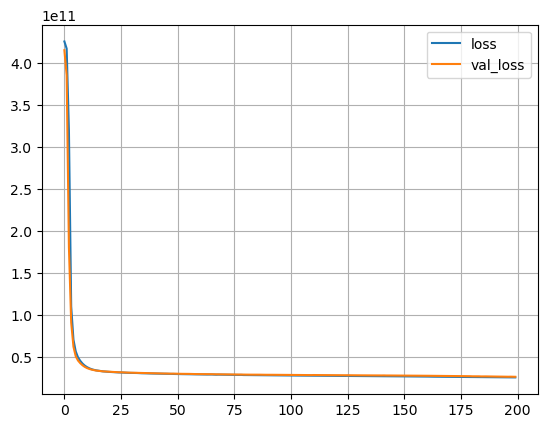

In [16]:
model.compile(loss=error_metric_used, optimizer=optimizer)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS*2, batch_size=1000, validation_split=.2, verbose=0)
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Early Stopping

Early stopping is very common with neural networks, due to the common pattern mentioned above of the optimal balance of over/under fitting occuring at some point within many, potentially dozens/hundreds/thousands, of epochs. Early stopping kills the process after it detects that validation loss is going back up. 

We can put early stopping in place by using a Keras function called a callback, which has odd syntax, but is quite simple to use. The patience pararmeter controls how many epcohs of worsening scores are tolerated before implementing the stop. The restore_best_weights tells the model to roll back all of its weights to the optimal point - so we automatically get the best model post-training. In most cases we probabyl want to use early stopping along with a high epoch number. We can let the model train, and just tell us when it is finished. 

Another parameter that we may want to implement is the "min_delta" parameter. This controls how much the validation loss needs to improve to be considered an improvement. If the validation loss is 0.1, and the min_delta is 0.01, then the model will stop if the validation loss goes up to 0.11, but not if it goes up to 0.12. This is useful if we have a very small validation loss, and we want to make sure that we are getting a significant improvement before stopping. In situations like the above one, where the loss is flat-ish, but bumps around a little, this may help deal with that noise and make the early stopping cutoffs work more in line with expectations.

<b>Note:</b> the patience parameter requires a little bit of thought, and a good value can vary a little between scenarios. We want to make sure that we are not stopping too early, if the patience is really small, we might get a situation where a local minima is reached and we stop the model as it is trying to escape it. If the patience is too large, we might not stop the model in time, as we might have many flat loss values, then one or two that are an improvement, resetting the clock and making the training process keep going far too long. We need to base it somewhat on what the model actually does - very stable loss results might mean we need a higher patience, while a model that is very volatile might need a lower patience, as we might not have long stable periods anywhere. Values between 5 and 15 or so are common, as are settings of around 10% of the number of epochs, but it is a good idea to test a few different values to see what works best - if you actually work with larger examples we'll run several trials with different parameters or model configurations with samples of the full dataset. These trials will likely give us an idea of a reasonable cutoff point for patience. Many of the patience settings in examples that are in the next few workbooks are probably lower than "ideal", this is entirely for practicality purposes - we might be cutting off some slightly more ideal models, but we are also saving a lot of time.

In [17]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(18, input_dim=18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(1))
#model.summary()

Epoch 1/300
260/260 [==============================] - 3s 10ms/step - loss: 411744632832.0000 - val_loss: 356742987776.0000
Epoch 2/300
260/260 [==============================] - 3s 10ms/step - loss: 258863071232.0000 - val_loss: 148558086144.0000
Epoch 3/300
260/260 [==============================] - 2s 8ms/step - loss: 103547568128.0000 - val_loss: 76725960704.0000
Epoch 4/300
260/260 [==============================] - 2s 8ms/step - loss: 74050387968.0000 - val_loss: 68627681280.0000
Epoch 5/300
260/260 [==============================] - 2s 8ms/step - loss: 68508176384.0000 - val_loss: 64635822080.0000
Epoch 6/300
260/260 [==============================] - 2s 8ms/step - loss: 64760057856.0000 - val_loss: 61427789824.0000
Epoch 7/300
260/260 [==============================] - 2s 7ms/step - loss: 61663268864.0000 - val_loss: 58647945216.0000
Epoch 8/300
260/260 [==============================] - 2s 6ms/step - loss: 58874863616.0000 - val_loss: 56166989824.0000
Epoch 9/300
260/260 [====

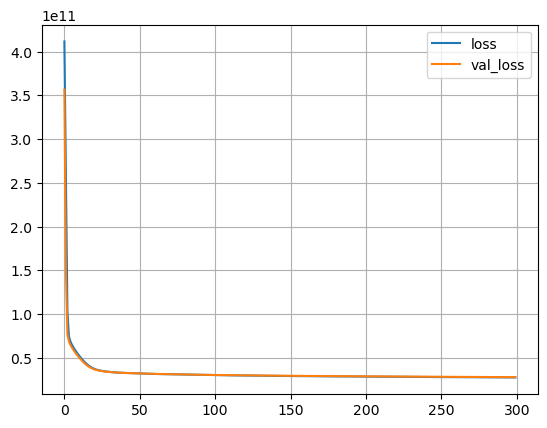

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True, min_delta=1000) 

model.compile(loss=error_metric_used, optimizer=optimizer)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS*3, batch_size=50, validation_split=.2, verbose=1, callbacks=[callback])
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Validation

One change in the way we normally setup our data in neural networks is that we are performing checks during the training process with "validation data". This is another split of the data, like train-test, but this validation data is used during training to check the model's progress. This allows the model to constantly calculate the accuracy of the model on new data, similar to how things would work inside of a cross-validation in a grid search. The key thing that we can use this for is that it allows us to calculate the current "test data" performance, which is the "validation loss" that we can use to evaluate the model and cut short training. This validation dataset is normally "good enough" to be an indicator of the expected performance of the model, just like the test scores we are used to. We could still do a train-test split prior to training, and calcuate that true test accuracy, but we don't really need to. In most cases, what we referred to as test accuracy in sklearn models is just the validation accuracy in neural networks.

### Early Stopping on Validation Loss

More likely than stopping when the training loss starts to increase, we'll want to stop when the validation loss starts to increase. This is because the validation loss is a better indicator of how the model will perform on new data. This is also what allows us to set a high epoch number and walk away while training happens - as long as our model has "room to grow", or the capacity to fit the data, we can let it train until we've reached a minimum validation loss.

![Early Stopping](images/early_stopping.png "Early Stopping")

<b>Note:</b> early stopping on the validation loss will probably be the most common "optimization" that we'll do. 

Epoch 1/300
227/227 [==============================] - 3s 11ms/step - loss: 27402954752.0000 - val_loss: 27161552896.0000
Epoch 2/300
227/227 [==============================] - 2s 11ms/step - loss: 27392065536.0000 - val_loss: 27171962880.0000
Epoch 3/300
227/227 [==============================] - 2s 9ms/step - loss: 27357827072.0000 - val_loss: 27165044736.0000
Epoch 4/300
227/227 [==============================] - 2s 8ms/step - loss: 27342704640.0000 - val_loss: 27151499264.0000
Epoch 5/300
227/227 [==============================] - 2s 8ms/step - loss: 27324078080.0000 - val_loss: 27182895104.0000
Epoch 6/300
227/227 [==============================] - 2s 11ms/step - loss: 27332057088.0000 - val_loss: 27158355968.0000
Epoch 7/300
227/227 [==============================] - 4s 18ms/step - loss: 27330957312.0000 - val_loss: 27141175296.0000
Epoch 8/300
227/227 [==============================] - 3s 11ms/step - loss: 27333187584.0000 - val_loss: 27138695168.0000
Epoch 9/300
227/227 [======

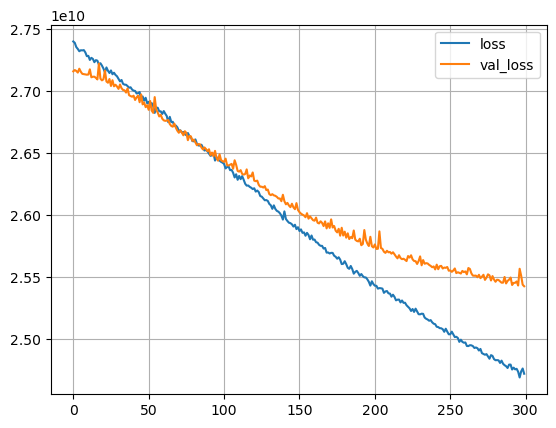

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, min_delta=2000) 

model.compile(loss=error_metric_used, optimizer=optimizer)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS*3, batch_size=50, validation_split=.3, verbose=1, callbacks=[callback])
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Regularization

Like other linear models, we can implement regularization to help tame overfitting. 

We can use both L2 (Ridge) regularization that will limit growth of coefficients, and L1 (Lasso) regularization that is able to eliminate features by shrinking their coefficients to 0. The functionality is the same as we are used to, a regularization term is added to the loss, and the optimization, such as gradient descent, is then performed as normal. 

In [20]:
# Regularization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(128, input_dim=18, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer="l1"))
model.add(Dense(128, activation='relu', kernel_regularizer="l2"))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 18)               37        
 ion)                                                            
                                                                 
 dense_14 (Dense)            (None, 128)               2432      
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 35,622
Trainable params: 35,585
Non-trainable params: 37
_________________________________________________

169/169 [==============================] - 1s 7ms/step - loss: 26230155264.0000


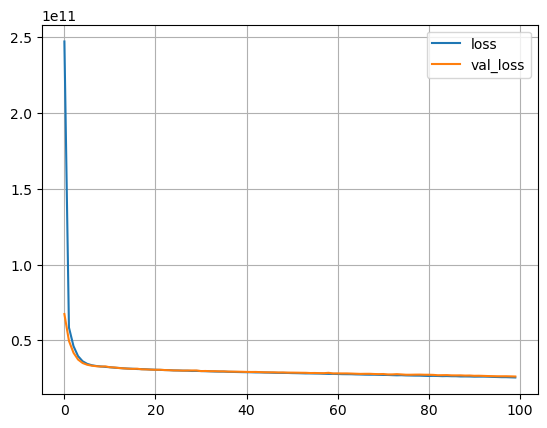

In [21]:
model.compile(loss=error_metric_used, optimizer=optimizer)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=100, validation_split=.2, verbose=0)
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Dropout

Neural networks also commonly employ a technique call dropouts to prevent overfitting. This works just like the name says, every time the data is moved from one layer to another some portion of the features are randomly held out from being used. The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own. This sounds somewhat weird, but is actually effective. The number of features held out is called the dropout rate, typically between .2 and .5. 

![Dropout](images/dropout.webp "Dropout")

An analogy can be drawn to the bootstrapping we looked at with trees - some random subset is selected each time, resulting in each batch getting "a slightly different look at the data", thus preventing overfitting. 

In [22]:
# Dropout
#Test Different Model Capacities
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = Sequential()
model.add(normalizer)
model.add(Dense(512, input_dim=18, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 18)               37        
 ion)                                                            
                                                                 
 dense_18 (Dense)            (None, 512)               9728      
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

169/169 [==============================] - 1s 4ms/step - loss: 15299556352.0000


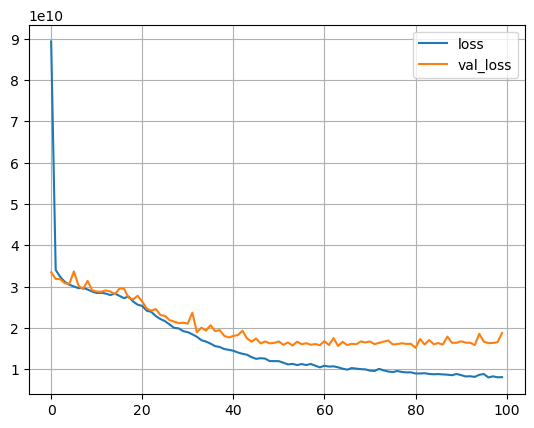

In [23]:
model.compile(loss=error_metric_used, optimizer=optimizer)
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=100, validation_split=.2, verbose=0)
model.evaluate(X_test, y_test)
plot_loss(train_log)

### Predictions

Once the model is trained, using it is mostly familiar to us from the sklearn stuff. 

In [24]:
preds = model.predict(X_test)
mean_absolute_error(y_test, preds)


169/169 [==============================] - 1s 3ms/step


71201.51280590767

### Exercise

Use the California data from previously and try to add some regularization things.

In [25]:
print(X_train_cal.shape, y_train_cal.shape)

(15480, 8) (15480, 1)


I'll mix in a couple of regularization things, this could be almost anything. 

In [26]:
# Dropout
#Test Different Model Capacities
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train_cal))

model = Sequential()
model.add(normalizer)
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu', kernel_regularizer="l1"))
model.add(Dropout(0.2))
model.add(Dense(6, activation='relu', kernel_regularizer="l2"))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_23 (Dense)            (None, 8)                 72        
                                                                 
 dense_24 (Dense)            (None, 8)                 72        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_25 (Dense)            (None, 6)                 54        
                                                                 
 dense_26 (Dense)            (None, 4)                 28        
                                                      

162/162 [==============================] - 1s 8ms/step - loss: 0.4423


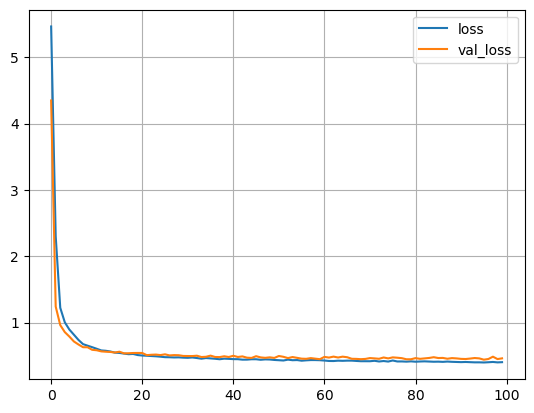

In [27]:

model.compile(loss=error_metric_used, optimizer=tf.optimizers.Adam(learning_rate=.001))
train_log = model.fit(X_train_cal, y_train_cal, epochs=BASE_EPOCHS, batch_size=70, validation_split=.3, verbose=0)
model.evaluate(X_test_cal, y_test_cal)
plot_loss(train_log)

### Customized Loss

Most scenarios are totally fine with a standard loss function, but what if we have something odd? What if we are playing on The Price is Right? We want to get as close as we can, without going over. We can write a loss function to mirror that! The Keras backend piece is basically a set of functions (like the "switch" we used, mean, sum, etc...) that are implemented in Tensorflow - they don't do anything differently from "normal" functions, but they are potentially more efficient.

More practically, some real life scenarios have a disperse impact of different types of error. For example, if you are working for a call centre and predicting the number of agents to staff. Having slightly too many may be an error that costs a little bit of money, but not that big of a deal. Predicting too few might incur serious penalties if callers wait and you violate an SLA. Being off in one direction is bad, being off in the other direction can cause you to "fall off of a cliff" so to speak. In cases where the impact of the error is not uniform, custom loss functions may make sense. 

<b>Note:</b> these custom loss functions work, but if you are going to put one into real use, you would likely want to look into ensuring the calculations are efficient and that you actually get a tangible benefit from the custom loss function. This one is kind of a goofy example, we will normally just want to use a standard loss function. Due to the wild differences if the residual is positive or negative, this one will likely yeild some pretty dramatic swings and variability. 

## Optional Exercise

Try to use the California data with a customized loss function. 

Note: this is a 20 way classification, so you'll probably want that many neurons on the output layer, an appropriate activation (softmax), and the y values will need to be run through np_utils.to_categorical. As well, think about the loss function, try categorical crossentropy.

We'll look at activation and loss functions more next week. 

In [28]:
import keras.backend as K

def priceIsRight(y_true, y_pred):
    return K.switch(
                    y_pred <= y_true, 
                    (y_true - y_pred) ** 2,
                    (y_true - y_pred) ** 4
                    )

Epoch 1/100
37/37 [==============================] - 2s 39ms/step - loss: 0.3990 - val_loss: 0.4451
Epoch 2/100
37/37 [==============================] - 1s 22ms/step - loss: 0.3976 - val_loss: 0.4571
Epoch 3/100
37/37 [==============================] - 1s 19ms/step - loss: 0.3945 - val_loss: 0.4529
Epoch 4/100
37/37 [==============================] - 1s 18ms/step - loss: 0.3839 - val_loss: 0.4299
Epoch 5/100
37/37 [==============================] - 1s 18ms/step - loss: 0.3909 - val_loss: 0.4527
Epoch 6/100
37/37 [==============================] - 1s 18ms/step - loss: 0.3833 - val_loss: 0.4548
Epoch 7/100
37/37 [==============================] - 1s 19ms/step - loss: 0.3956 - val_loss: 0.4639
Epoch 8/100
37/37 [==============================] - 1s 18ms/step - loss: 0.3904 - val_loss: 0.4598
Epoch 9/100
37/37 [==============================] - 1s 20ms/step - loss: 0.3813 - val_loss: 0.4613
Epoch 10/100
37/37 [==============================] - 1s 21ms/step - loss: 0.3815 - val_loss: 0.4596

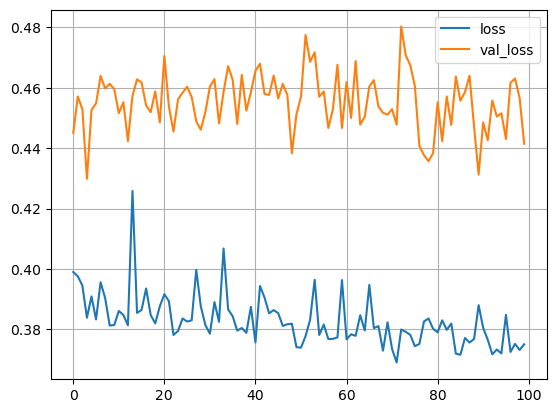

In [29]:
model.compile(loss=priceIsRight, optimizer=tf.optimizers.Adam(learning_rate=.001))
train_log = model.fit(X_train_cal, y_train_cal, epochs=BASE_EPOCHS, batch_size=300, validation_split=.3, verbose=1)
model.evaluate(X_test_cal, y_test_cal)
plot_loss(train_log)

## Big Exercise - Newsgroup Classification

Try to classify the newsgroup data. Use these details for the network structure:
<ul>
<li> Loss function: categorical crossentropy. </li>
<li> Output function - 20 nodes (one per class), softmax activation. </li>
</ul>

In [30]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

remove = ("headers", "footers", "quotes")

data_train = fetch_20newsgroups(
    subset="train", shuffle=True, remove=remove)

data_test = fetch_20newsgroups(
    subset="test", shuffle=True, remove=remove)

In [31]:
news_tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode")
X_train = news_tf.fit_transform(data_train.data)
y_train = data_train.target
X_test = news_tf.transform(data_test.data)
y_test = data_test.target
print("Train:", X_train.shape, "  Test:", X_test.shape)

Train: (11314, 1971374)   Test: (7532, 1971374)


In [32]:
y_test = np_utils.to_categorical(y_test)
y_train = np_utils.to_categorical(y_train)

In [33]:
in_size = 200
tsvd = TruncatedSVD(n_components=in_size)
X_train = tsvd.fit_transform(X_train)
X_test = tsvd.transform(X_test)

In [34]:
model = Sequential()
model.add(Dense(in_size*3, input_dim=in_size, activation='relu'))
model.add(Dense(in_size*3, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size*3, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(in_size, activation='relu'))
model.add(Dense(20, activation="softmax"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 600)               120600    
                                                                 
 dense_29 (Dense)            (None, 600)               360600    
                                                                 
 dropout_3 (Dropout)         (None, 600)               0         
                                                                 
 dense_30 (Dense)            (None, 600)               360600    
                                                                 
 dropout_4 (Dropout)         (None, 600)               0         
                                                                 
 dense_31 (Dense)            (None, 400)               240400    
                                                                 
 dropout_5 (Dropout)         (None, 400)              

Epoch 1/100
91/91 [==============================] - 4s 35ms/step - loss: 2.8139 - accuracy: 0.0913 - val_loss: 2.4042 - val_accuracy: 0.1878
Epoch 2/100
91/91 [==============================] - 2s 24ms/step - loss: 1.9278 - accuracy: 0.3431 - val_loss: 1.6653 - val_accuracy: 0.4587
Epoch 3/100
91/91 [==============================] - 2s 22ms/step - loss: 1.4248 - accuracy: 0.5334 - val_loss: 1.3850 - val_accuracy: 0.5537
Epoch 4/100
91/91 [==============================] - 2s 24ms/step - loss: 1.2179 - accuracy: 0.6009 - val_loss: 1.3792 - val_accuracy: 0.5868
Epoch 5/100
91/91 [==============================] - 2s 26ms/step - loss: 1.0670 - accuracy: 0.6609 - val_loss: 1.2577 - val_accuracy: 0.6147
Epoch 6/100
91/91 [==============================] - 2s 27ms/step - loss: 0.9660 - accuracy: 0.6978 - val_loss: 1.2439 - val_accuracy: 0.6253
Epoch 7/100
91/91 [==============================] - 2s 23ms/step - loss: 0.8492 - accuracy: 0.7309 - val_loss: 1.3027 - val_accuracy: 0.6213
Epoch 

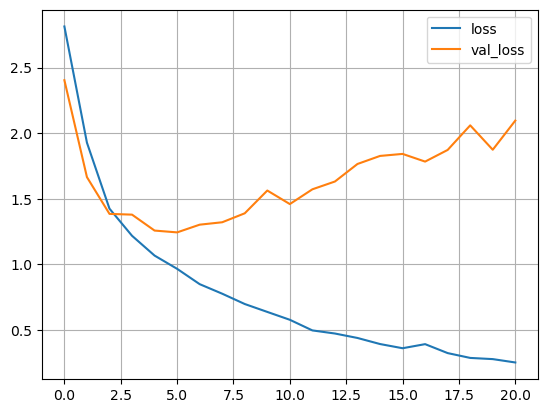

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) 

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
train_log = model.fit(X_train, y_train, epochs=BASE_EPOCHS, batch_size=100, validation_split=.2, verbose=1, callbacks=[callback])
model.evaluate(X_test, y_test)
plot_loss(train_log)

## Neural Network Tuning Summary vs Reality

The techniques above generally expose a pattern that we can use to make accurate models:
<ul>
<li> Create a model that is accurate and overfitted. (Or setup process to generate an overfitted model)
<li> Use hyperparameter tuning-ish methods to trial several different models. 
<li> Use tools such as regularization and early stopping to "trim" the overfitting back. 
</ul>

For the most part, for what we are doing, this will probably work fine, without forcing us to put a tonne of thought into things upfront; we can just make a large model, then reduce it. In practice the main downside to this type of brute force approach is time, and by extension, cost. For us the datasets are mostly small enough that in an extreme case we could do something like setup a bunch of trials, let our computer train and test overnight, and wake up to a model that is pretty good. If our data was scaled up by a factor of 10,000 this becomes less practical. We would want to sample the data to make each trial run much more quickly, but we'd still be dealing with a non-trivial amount of processing time for each model that we want to try. Doing things that reduce the processing requirements of each epoch, such as feature selection, choosing a "correctly" sized model, or smart sets of hyperparameters to try, will reduce the amount of "bad" trials, and allow us to dedicate more time to "good" trials. This is one of the, relatively rare, scenarios that paying attention to processing time can have massive impacts on the end results. We'll look more at making a good sized model next. 